In [1]:
# Import necessary packages
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
torch.cuda.device_count()  # print 1
import torchdeepretina as tdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchdeepretina.io as tdrio
import torchdeepretina.utils as tdrutils
import stimuli as s
import torchdeepretina.stimuli as tdrstim
from tqdm import tqdm
from itertools import repeat
from matplotlib import ticker, cm

f2_response is unavailable until you run:
$ pip install -e git+git://github.com/nirum/jetpack.git@master#egg=jetpack


In [2]:
device = torch.device("cuda:0")

# load model given path
def load_model(model_path):
    """
    in: model_path
    out: model
    """
    model = tdrio.load_model(model_path)
    model.to(device)
    model.eval()
    return model

# path to the directory
model_dir_path = '/home/htanaka/torch-deep-retina/models_paper/'#/tanaka/convgc_models/gcchansearch_57_chans[4, 4]/'

# number of ganglion cells
n_chans=17

# load model
model_n_path = 'convgc_15-11-21b_naturalscene'
model_n = load_model(model_dir_path + model_n_path + '.pt')
model_n = tdr.utils.stacked2conv(model_n)

#model_n_path = 'convgc_15-10-07_naturalscene'
# model_n = load_model(model_dir_path + model_n_path)
# model_n = tdr.utils.stacked2conv(model_n)
#model_n_path = '15-11-21b_naturalscene.pt'

In [3]:
# Motion anticipation
def motion_anticipation(velocity=0.08, width=4, flash_duration=2, filt_depth=40):
    c_right, speed_right, stim_right = tdrstim.driftingbar(velocity,    
                                                 width, x=(-30, 30))    
    rightward_moving_bar = torch.from_numpy(stim_right)
    c_left, speed_left, stim_left = tdrstim.driftingbar(-velocity,      
                                               width, x=(30, -30))      
    leftward_moving_bar = torch.from_numpy(stim_left)
    flash_centers = np.arange(-25, 26)
    flashes = (tdrstim.flash(flash_duration, 43, 70,                    
                        intensity=tdrstim.bar((x, 0), width, 50)) for x in flash_centers)
    xs = []
    for f in flashes:
        x = torch.from_numpy(tdrstim.concat(f, nh=filt_depth))
        xs.append(x)
    return xs, rightward_moving_bar, c_right, leftward_moving_bar, c_left

In [ ]:
# Data generation
flash, rightward_moving_bar, c_right, leftward_moving_bar, c_left = motion_anticipation(velocity=0.08, width=4, flash_duration=2, filt_depth=40)
integ_steps=100

for i in range(n_chans):
    x_r = rightward_moving_bar
    x_l = leftward_moving_bar
    integrad_r, response_r = tdrutils.integrated_gradient(model=model_n, X=x_r, layer="sequential.0", chans=i, alpha_steps=100)
    integrad_l, response_l = tdrutils.integrated_gradient(model=model_n, X=x_l, layer="sequential.0", chans=i, alpha_steps=100)
    integrad_r, resopnse_r, integrad_l, resopnse_l = integrad_r.numpy(), response_r.numpy(), integrad_l.numpy(), response_l.numpy()
    outfile_integrad = './analysis_data/'+model_n_path+'/motion_anticipation/integrad_r_chan_'+str(i)+'_steps_'+str(integ_steps)+'.npy'
    outfile_response = './analysis_data/'+model_n_path+'/motion_anticipation/response_r_chan_'+str(i)+'_steps_'+str(integ_steps)+'.npy'
    np.save(outfile_integrad, integrad_r)
    np.save(outfile_response, response_r)
    
    outfile_integrad = './analysis_data/'+model_n_path+'/motion_anticipation/integrad_l_chan_'+str(i)+'_steps_'+str(integ_steps)+'.npy'
    outfile_response = './analysis_data/'+model_n_path+'/motion_anticipation/response_l_chan_'+str(i)+'_steps_'+str(integ_steps)+'.npy'
    #np.save(outfile_integrad, integrad_l)
    #np.save(outfile_response, response_l)

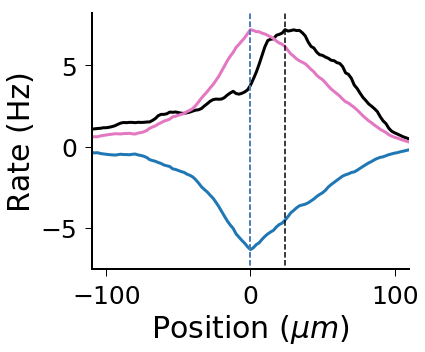

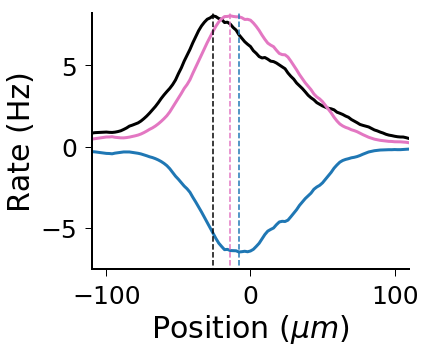

In [5]:
# generate stimuli
flash, rightward_moving_bar, c_right, leftward_moving_bar, c_left = motion_anticipation(velocity=0.08, width=4, flash_duration=2, filt_depth=40)
# integration steps
integ_steps=100

# add values with the same key from two dictionaries
def add_dict(dict_1, dict_2):
    for key in dict_2.keys():
        try:
            dict_1[key] += dict_2[key]
        except KeyError:
            dict_1.update({key:dict_2[key]})
    return dict_1

def arrays_to_dict(array_1, array_2):
    return {k:v for k,v in zip(array_1, array_2)}

# initialize dictionaries
R_r_dict_sum      = {}
IG_r_exc_dict_sum = {}
IG_r_inh_dict_sum = {}
R_l_dict_sum      = {}
IG_l_exc_dict_sum = {}
IG_l_inh_dict_sum = {}

n_chans = 5
#4,5,7,10,16
# loop over output ganglion cells
for i in [4,5,7,10,16]:#range(17):
    # read integrated_gradients, response files
    integrad_file_r = './analysis_data/'+model_n_path+'/motion_anticipation/integrad_r_chan_'+str(i)+'_steps_'+str(integ_steps)+'.npy'
    response_file_r = './analysis_data/'+model_n_path+'/motion_anticipation/response_r_chan_'+str(i)+'_steps_'+str(integ_steps)+'.npy'
    integrad_file_l = './analysis_data/'+model_n_path+'/motion_anticipation/integrad_l_chan_'+str(i)+'_steps_'+str(integ_steps)+'.npy'
    response_file_l = './analysis_data/'+model_n_path+'/motion_anticipation/response_l_chan_'+str(i)+'_steps_'+str(integ_steps)+'.npy'
    
    IG_r = np.load(integrad_file_r) 
    R_r  = np.load(response_file_r)
    IG_l = np.load(integrad_file_l) 
    R_l  = np.load(response_file_l)

    # determine peaks of response induced by a bar moving left/right 
    peak_r = c_right[40:][np.argmax(R_r)]
    peak_l = c_left[40:][np.argmax(R_l)] 
    # compute the location of the center of the receptive field and round the value
    recep_field_center = int(((peak_r+peak_l)/2)/np.diff(c_right)[0])*np.diff(c_right)[0]
    #
    positions_r = np.round( (c_right[40:]-recep_field_center)*25 ,3).tolist()
    #positions_r = np.round( (center[i]-c_right[40:341])*25 ,3).tolist()
    
    exc_r = (np.sum(IG_r, axis=(0,2,3))>0)
    inh_r = (np.sum(IG_r, axis=(0,2,3))<0)  

#     exc_r = ((np.sum(IG_r, axis=(0,2,3))*(on_off>0))>0) 
#     inh_r = ((np.sum(IG_r, axis=(0,2,3))*(on_off>0))<0)

#     exc_r = ((np.sum(IG_r, axis=(0,2,3))*(on_off<0))>0) 
#     inh_r = ((np.sum(IG_r, axis=(0,2,3))*(on_off<0))<0)


    R_r_dict      = arrays_to_dict(positions_r, R_r[:,0])
    IG_r_exc_dict = arrays_to_dict(positions_r, np.sum(IG_r[:,exc_r,:,:], axis=(1,2,3)))
    IG_r_inh_dict = arrays_to_dict(positions_r, np.sum(IG_r[:,inh_r,:,:], axis=(1,2,3)))
    R_r_dict_sum      = add_dict(R_r_dict_sum, R_r_dict)
    IG_r_exc_dict_sum = add_dict(IG_r_exc_dict_sum, IG_r_exc_dict)
    IG_r_inh_dict_sum = add_dict(IG_r_inh_dict_sum, IG_r_inh_dict)
    #
    positions_l = np.round( (c_left[40:]-recep_field_center)*25 ,3).tolist()    
    #positions_l = np.round( (center[i]-c_left[40:341])*25 ,3).tolist()
    exc_l = (np.sum(IG_l, axis=(0,2,3))>0)
    inh_l = (np.sum(IG_l, axis=(0,2,3))<0) 

#     exc_l = ((np.sum(IG_l, axis=(0,2,3))*(on_off>0))>0) 
#     inh_l = ((np.sum(IG_l, axis=(0,2,3))*(on_off>0))<0)

#     exc_l = ((np.sum(IG_l, axis=(0,2,3))*(on_off<0))>0) 
#     inh_l = ((np.sum(IG_l, axis=(0,2,3))*(on_off<0))<0)

    R_l_dict      = arrays_to_dict(positions_l, R_l[:,0])
    IG_l_exc_dict = arrays_to_dict(positions_l, np.sum(IG_l[:,exc_l,:,:], axis=(1,2,3)))
    IG_l_inh_dict = arrays_to_dict(positions_l, np.sum(IG_l[:,inh_l,:,:], axis=(1,2,3)))
    R_l_dict_sum      = add_dict(R_l_dict_sum, R_l_dict)
    IG_l_exc_dict_sum = add_dict(IG_l_exc_dict_sum, IG_l_exc_dict)
    IG_l_inh_dict_sum = add_dict(IG_l_inh_dict_sum, IG_l_inh_dict)





fig, ax = plt.subplots(1, 1, figsize=(6,5))
# Set line width of axes
ax.spines["top"].set_linewidth(0)
ax.spines["bottom"].set_linewidth(2)
ax.spines["right"].set_linewidth(0)
ax.spines["left"].set_linewidth(2)

# Turn on/off axes, ticks, change width, labelsize
ax.tick_params(axis="both", which="both", bottom=True, top=False,
               labelbottom=True, left=True, right=False,
               labelleft=True,direction='out',length=7,width=1.0,pad=8,labelsize=25)

max_R_l = np.max(np.array([R_l_dict_sum[x]      for x in np.sort(list(R_l_dict_sum.keys()))])/n_chans)
max_IG_l = np.max(np.array([IG_l_exc_dict_sum[x] for x in np.sort(list(IG_l_exc_dict_sum.keys()))])/n_chans)

plt.plot( np.sort( list(R_l_dict_sum.keys())      ), np.array([R_l_dict_sum[x]      for x in np.sort(list(R_l_dict_sum.keys()))])/n_chans, ls='-', c='k', lw=3, label='Rate'  )
plt.plot( np.sort( list(IG_l_exc_dict_sum.keys()) ), (max_R_l/max_IG_l) * np.array([IG_l_exc_dict_sum[x] for x in np.sort(list(IG_l_exc_dict_sum.keys()))])/n_chans,     c=plt.cm.tab10(6), lw=3, label='Excitatory')
plt.plot( np.sort( list(IG_l_inh_dict_sum.keys()) ), (max_R_l/max_IG_l) * np.array([IG_l_inh_dict_sum[x] for x in np.sort(list(IG_l_inh_dict_sum.keys()))])/n_chans,     c=plt.cm.tab10(0), lw=3, label='Inhibitory')

peak_R_l = np.sort( list(R_l_dict_sum.keys()) )[np.argmax([R_l_dict_sum[x] for x in np.sort(list(R_l_dict_sum.keys()))])]
peak_IG_l_exc = np.sort( list(IG_l_exc_dict_sum.keys()) )[np.argmax([IG_l_exc_dict_sum[x] for x in np.sort(list(IG_l_exc_dict_sum.keys()))])]
peak_IG_l_inh = np.sort( list(IG_l_inh_dict_sum.keys()) )[np.argmin( [IG_l_inh_dict_sum[x] for x in np.sort(list(IG_l_inh_dict_sum.keys()))] )] 

# print( peak_R_l )
# print(peak_IG_l_exc)
# print(peak_IG_l_inh)

plt.plot(np.zeros(50)+peak_R_l, np.linspace(-40,65,50), c='k', ls='--')
plt.plot(np.zeros(50)+peak_IG_l_exc, np.linspace(-40,65,50), c=plt.cm.tab10(6), ls='--')
plt.plot(np.zeros(50)+peak_IG_l_inh, np.linspace(-40,65,50), c=plt.cm.tab10(0), ls='--')

#plt.legend(fontsize=20,frameon=False)
plt.xlabel('Position ($\mu m$)', size=30)
plt.ylabel('Rate (Hz)', size=30)
plt.xlim(-110,110)
plt.ylim(-7.5,8.2)
plt.tight_layout()
#plt.savefig('./Journal_Figures/Motion_Anticipation_left.pdf')
#plt.xlabel('Position ($\mu m$)', fontsize=25)


fig, ax = plt.subplots(1, 1, figsize=(6,5))
# Set line width of axes
ax.spines["top"].set_linewidth(0)
ax.spines["bottom"].set_linewidth(2)
ax.spines["right"].set_linewidth(0)
ax.spines["left"].set_linewidth(2)

# Turn on/off axes, ticks, change width, labelsize
ax.tick_params(axis="both", which="both", bottom=True, top=False,
               labelbottom=True, left=True, right=False,
               labelleft=True,direction='out',length=7,width=1.0,pad=8,labelsize=25)

max_R_r  = np.max( np.array([R_r_dict_sum[x]      for x in np.sort(list(R_r_dict_sum.keys()))])/n_chans )
max_IG_r = np.max( np.array([IG_r_exc_dict_sum[x] for x in np.sort(list(IG_r_exc_dict_sum.keys()))])/n_chans )

plt.plot( np.sort( list(R_r_dict_sum.keys())      ), np.array([R_r_dict_sum[x]      for x in np.sort(list(R_r_dict_sum.keys()))])/n_chans, ls='-', c='k', lw=3, label='Rate'  )
plt.plot( np.sort( list(IG_r_exc_dict_sum.keys()) ), (max_R_r/max_IG_r) * np.array([IG_r_exc_dict_sum[x] for x in np.sort(list(IG_r_exc_dict_sum.keys()))])/n_chans,     c=plt.cm.tab10(6), lw=3, label='Excitatory')
plt.plot( np.sort( list(IG_r_inh_dict_sum.keys()) ), (max_R_r/max_IG_r) * np.array([IG_r_inh_dict_sum[x] for x in np.sort(list(IG_r_inh_dict_sum.keys()))])/n_chans,     c=plt.cm.tab10(0), lw=3, label='Inhibitory')

peak_R_r = np.sort( list(R_r_dict_sum.keys()) )[np.argmax([R_r_dict_sum[x] for x in np.sort(list(R_r_dict_sum.keys()))])]
peak_IG_r_exc = np.sort( list(IG_r_exc_dict_sum.keys()) )[np.argmax([IG_r_exc_dict_sum[x] for x in np.sort(list(IG_r_exc_dict_sum.keys()))])]
peak_IG_r_inh = np.sort( list(IG_r_inh_dict_sum.keys()) )[np.argmin( [IG_r_inh_dict_sum[x] for x in np.sort(list(IG_r_inh_dict_sum.keys()))] )] 

# print( peak_R_r )
# print( peak_IG_r_exc )
# print( peak_IG_r_inh )

plt.plot(np.zeros(50)+peak_R_r, np.linspace(-40,65,50), c='k', ls='--')
plt.plot(np.zeros(50)+peak_IG_r_exc, np.linspace(-40,65,50), c=plt.cm.tab10(6), ls='--')
plt.plot(np.zeros(50)+peak_IG_r_inh, np.linspace(-40,65,50), c=plt.cm.tab10(0), ls='--')

#plt.legend(fontsize=20,frameon=False)
plt.xlabel('Position ($\mu m$)', size=30)
plt.ylabel('Rate (Hz)', size=30)
plt.xlim(-110,110)
plt.ylim(-7.5,8.2)
plt.tight_layout()
#plt.savefig('./Journal_Figures/Motion_Anticipation_right.pdf')
#plt.show()


